**1. Read and import data**

In [456]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [457]:
dataset = pd.read_csv('./data/salary.csv', sep='|')

In [458]:
dataset.head(2)

,id,job_title,location,salary_currency,career_level,experience_level,education_level,employment_type,job_function,job_benefits,company_process_time,company_size,company_industry,job_description,salary
0,1,Facility Maintenance & Smart Warehouse Manager,Bandung,IDR,Manajer/Asisten Manajer,5 tahun,"Sertifikat Professional, D3 (Diploma), D4 (Dip...",Penuh Waktu,"Manufaktur,Pemeliharaan",NaN,NaN,NaN,NaN,Deskripsi PekerjaanRequirements :D3/SI from re...,NaN
1,2,Procurement Department Head,Jakarta Raya,IDR,Manajer/Asisten Manajer,5 tahun,"Sarjana (S1), Diploma Pascasarjana, Gelar Prof...",Penuh Waktu,"Manufaktur,Pembelian/Manajemen Material",NaN,25 days,51 - 200 pekerja,Manajemen/Konsulting HR,Job Role: 1. Responsible for material availabi...,NaN


**2. Cleaning the data**

In [459]:
# Remove Column $ Null Value 
dataset = dataset.drop(labels=["salary_currency", "job_benefits", "job_function", "job_description",
"company_process_time"], axis=1)
dataset.dropna(inplace=True)

In [460]:
# Nampilin tipe kolom "Object" & "Number"
objectType  = dataset.select_dtypes(['object']).columns
numericType  = dataset.select_dtypes(['number']).columns
print(objectType)
print(numericType)

Index(['job_title', 'location', 'career_level', 'experience_level',
       'education_level', 'employment_type', 'company_size',
       'company_industry'],
      dtype='object')
Index(['id', 'salary'], dtype='object')


In [461]:
# Check null values
dataset.isnull().sum()

id                  0
job_title           0
location            0
career_level        0
experience_level    0
education_level     0
employment_type     0
company_size        0
company_industry    0
salary              0
dtype: int64

In [462]:
dataset[numericType].describe()

,id,salary
count,7338.000000,7.338000e+03
mean,21364.472200,7.836481e+06
std,11139.744178,2.405146e+07
min,10.000000,1.000000e+01
25%,11641.250000,4.500000e+06
50%,23275.000000,5.800000e+06
75%,32380.750000,8.500000e+06
max,34746.000000,2.000000e+09


**3. Discovering the data**

Top 10 Job Have The Highest Average Salary

Top 10 Region Have The Highest Average Salary

In [463]:
topRegion = dataset[["location","salary"]]
topRegion = topRegion[(topRegion.groupby(['location'])['location'].transform('count') > 10)]
topRegion.set_index("location", inplace=True)

In [464]:
topRegion.groupby(['location'])['salary'].mean().astype(int).nlargest(10)

location
Tangerang             12012053
Sumatera Utara        11809320
Sulawesi Tengah        9735714
Jakarta Raya           9672055
Aceh                   9519090
Bali                   9458268
Jakarta Selatan        9450509
Kalimantan Selatan     8723076
Cikarang               7980941
Sumatera Selatan       7933940
Name: salary, dtype: int32

Kind of Company

Average Salary by size of Company

Kind of Career Level

In [465]:
CL = dataset["career_level"]
tableCareer = dataset[["career_level"]]
tableCareer["count_career"] = tableCareer.groupby(['career_level'])['career_level'].transform('count')

c:\Program Files\Microsoft SQL Server\150\PYTHON_SERVER\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


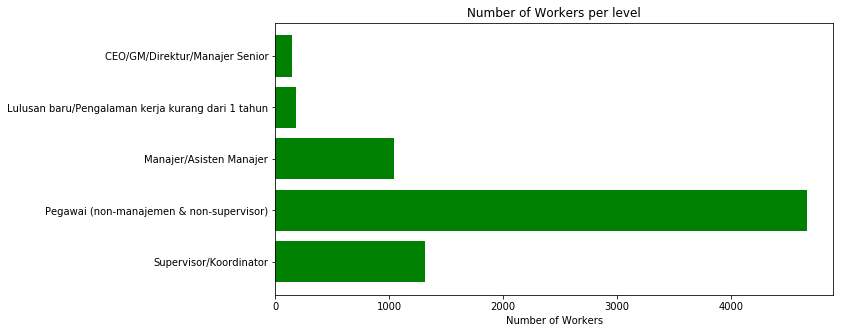

In [466]:
xCareer = list(tableCareer.loc[:, "career_level"])
yCareer = list(tableCareer.loc[:, "count_career"])

plt.figure(figsize=(10, 5))
plt.barh(xCareer, yCareer, color='green')
plt.title("Number of Workers per level")
plt.xlabel("Number of Workers")
plt.show()

Average Salary by size of Career Level

In [467]:
dataset.groupby(by="career_level")["salary"].mean().round(0).astype("int").nlargest()

career_level
CEO/GM/Direktur/Manajer Senior                       24708745
Manajer/Asisten Manajer                              13427828
Supervisor/Koordinator                                7901489
Pegawai (non-manajemen & non-supervisor)              6160495
Lulusan baru/Pengalaman kerja kurang dari 1 tahun     5221986
Name: salary, dtype: int32

**4. Predict the salary**